Please run all cells of the following 2 sections to load MNIST images, Trained weights and to set-up necessary functions  

## **Load image**

In [ ]:
#loading 100 test images 

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
transform = transforms.ToTensor()
test_data =  datasets.MNIST(root='../Data', train=False, download=True, transform=transform)
test_load_all = DataLoader(test_data, batch_size=100, shuffle=False)

for X_test, y_test in test_load_all:
  break


Extracting ../Data/MNIST/raw/train-images-idx3-ubyte.gz to ../Data/MNIST/raw


Extracting ../Data/MNIST/raw/train-labels-idx1-ubyte.gz to ../Data/MNIST/raw


Extracting ../Data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../Data/MNIST/raw




Extracting ../Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../Data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
import matplotlib.pyplot as plt

def binact(tensor):
  tensor = np.sign(tensor)+1
  tensor = tensor/2
  return tensor

def mysoft(z):
  sum = np.sum(np.exp(z))
  output = np.zeros_like(z)
  for i in range(len(z)):
    temp = np.exp(z[i])
    output[i] = temp/sum
  res = np.argmax(output)
  return res

## **Functions**

In [ ]:
import numpy as np
import time
!pip install z3-solver
from z3 import *

In [ ]:
#
fc1weight = np.load("./fc1weight.npy")
fc2weight = np.load("./fc2weight.npy")

In [ ]:
# z3solve formulates the sat for the network. here i have 3 layers.
# Input (784 nodes) -> 1 fully connected layer (300 nodes) -> Output (10 nodes)

def z3solve(toggle,img,id,fc1weight,fc2weight,y_test):
  s = z3.Solver()
  bit = 784
  xgen = [Bool("Xgen{0}".format(x)) for x in range(bit)]
  xinp = [Bool("Xinp{0}".format(x)) for x in range(bit)]
  for i in range(bit):
    xinp[i] = bool(img[i])

  #doing XOR with input and random variables. PbEq mean sum of the XOR output = toggled inputs

  clause = []

  for i in range(len(xinp)):
    clause.append(Xor(xgen[i], xinp[i]))  
  s.add(PbEq([(x,1) for x in clause],toggle))

  z = [Bool("Z{0}".format(x)) for x in range(300)]
  y = [Bool("Y{0}".format(x)) for x in range(10)]


  node1 = []
  for node in range(300):
    bsat = 0
    clause1 = []
    for i in range(bit):
      if (fc1weight[node][i] == -1):
        bsat = bsat + 1
        clause1.append(Not(xgen[i]))
      else:
        clause1.append(xgen[i])

    #this is the hidden layer

    s.add(If(PbGe([(x,1) for x in clause1],bsat),z[node]==True,z[node]==False))

   
  #the final output layer 

  for node in range(10):
    bsat = 0
    clause3 = []

    for i in range(300):
      if (fc2weight[node][i] == -1):
        bsat = bsat + 1
        clause3.append(Not(z[i]))
      else:
        clause3.append(z[i])


    s.add(If(PbGe([(x,1) for x in clause3],bsat),y[node]==True,y[node]==False))


  #condition so that real label is not predicted 

  final = []
  for i in range(10):
    final.append(y[i]) 
  s.add(PbEq([(x,1) for x in final],1))
  label = y_test[id]
  s.add(y[label]==False)

  return s,xgen


In [ ]:
#sets the timeout and checks if the equation is satisfiable

def check(s,t):
  flag=0
  start = time.time()
  s.set(timeout=1000*t)
  s.check()
  end = time.time()
  print(f'{end-start} seconds')
  # s.model()
  if (end-start)>=t:
    flag = 1
  return s,flag

In [ ]:
#evaluates the model and decodes input from it storing in 'new' variable

def evalmodel(s,xgen):
  
  temp = []
  m = s.model()
  for i in range(784):    
    if m.evaluate(xgen[i]) == True:
      temp.append(1)
    else:
      temp.append(0)
  new = np.array(temp)
  return new


In [ ]:
#takes the generated perturbed image to check the wrong classification 

def predict(new,id):
  # flag = 0
  wrong = 0
  xnew = new
  y = np.matmul(fc1weight,xnew)
  y = binact(y)
  z = np.matmul(fc2weight,y)
  pred = mysoft(z)
  label = y_test[id].numpy()
  if (pred!=label):
    print(f'{label} is predicting {pred}')
    wrong = 1
  else:
    print(f'{label} is predicting {pred}')
    # flag = 1
  return wrong

Inside the Result section (toggle, t, start_id, end_id) can be changed

## **Result**

In [ ]:
# no of toggle pixels
toggle = 25 

# 100 second timeout
t = 100 

tot_wrong = 0

start_id = 50
end_id = 80

for id in range(start_id,end_id):
  img = X_test[id].view(784).sign().numpy()
  s,xgen = z3solve(toggle, img, id, fc1weight, fc2weight,y_test)
  s,flag = check(s,t)
  if flag==0:
    new = evalmodel(s,xgen)
    tot_wrong = tot_wrong + predict(new,id)
  print(f'Done {id}')
print(f'{tot_wrong} wrong')

100.01335287094116 seconds
Done 50
18.3769953250885 seconds
3 is predicting 5
Done 51
96.8565456867218 seconds
5 is predicting 3
Done 52
100.02497124671936 seconds
Done 53
88.78017592430115 seconds
6 is predicting 2
Done 54
100.02368378639221 seconds
Done 55
100.01316809654236 seconds
Done 56
100.02217817306519 seconds
Done 57
50.74818968772888 seconds
9 is predicting 7
Done 58
32.797038078308105 seconds
5 is predicting 7
Done 59
100.02525591850281 seconds
Done 60
100.02107238769531 seconds
Done 61
62.63508129119873 seconds
9 is predicting 2
Done 62
100.01655530929565 seconds
Done 63
62.20276379585266 seconds
7 is predicting 3
Done 64
100.02043175697327 seconds
Done 65
89.19730997085571 seconds
6 is predicting 3
Done 66
48.09654521942139 seconds
4 is predicting 7
Done 67
100.01779556274414 seconds
Done 68
100.02158164978027 seconds
Done 69
100.01849627494812 seconds
Done 70
100.02834224700928 seconds
Done 71
100.0215117931366 seconds
Done 72
24.017374515533447 seconds
9 is predicting 7

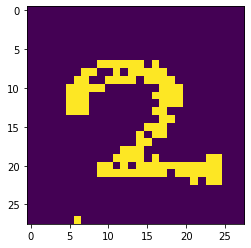

In [ ]:
#plot the latest misclassified image 

import matplotlib.pyplot as plt
plt.imshow(new.reshape(28,28))

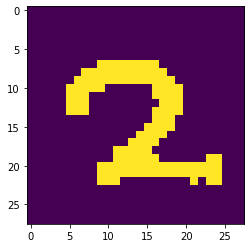

In [ ]:
# plt.imshow(X_test[77].sign().view(28,28).numpy())